# Transfer Learning with MobileNetV2

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

In [2]:
BATCH_SIZE = 256
IMG_SIZE = (160, 160)
train_directory = "train/"
val_directory = "valid/"
train_dataset = image_dataset_from_directory(train_directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             
                                             )
validation_dataset = image_dataset_from_directory(val_directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             
                                             )

Found 7946 files belonging to 70 classes.
Found 700 files belonging to 70 classes.


In [3]:
train_dataset.class_names

['Afghan',
 'African Wild Dog',
 'Airedale',
 'American Hairless',
 'American Spaniel',
 'Basenji',
 'Basset',
 'Beagle',
 'Bearded Collie',
 'Bermaise',
 'Bichon Frise',
 'Blenheim',
 'Bloodhound',
 'Bluetick',
 'Border Collie',
 'Borzoi',
 'Boston Terrier',
 'Boxer',
 'Bull Mastiff',
 'Bull Terrier',
 'Bulldog',
 'Cairn',
 'Chihuahua',
 'Chinese Crested',
 'Chow',
 'Clumber',
 'Cockapoo',
 'Cocker',
 'Collie',
 'Corgi',
 'Coyote',
 'Dalmation',
 'Dhole',
 'Dingo',
 'Doberman',
 'Elk Hound',
 'French Bulldog',
 'German Sheperd',
 'Golden Retriever',
 'Great Dane',
 'Great Perenees',
 'Greyhound',
 'Groenendael',
 'Irish Spaniel',
 'Irish Wolfhound',
 'Japanese Spaniel',
 'Komondor',
 'Labradoodle',
 'Labrador',
 'Lhasa',
 'Malinois',
 'Maltese',
 'Mex Hairless',
 'Newfoundland',
 'Pekinese',
 'Pit Bull',
 'Pomeranian',
 'Poodle',
 'Pug',
 'Rhodesian',
 'Rottweiler',
 'Saint Bernard',
 'Schnauzer',
 'Scotch Terrier',
 'Shar_Pei',
 'Shiba Inu',
 'Shih-Tzu',
 'Siberian Husky',
 'Vizsla',

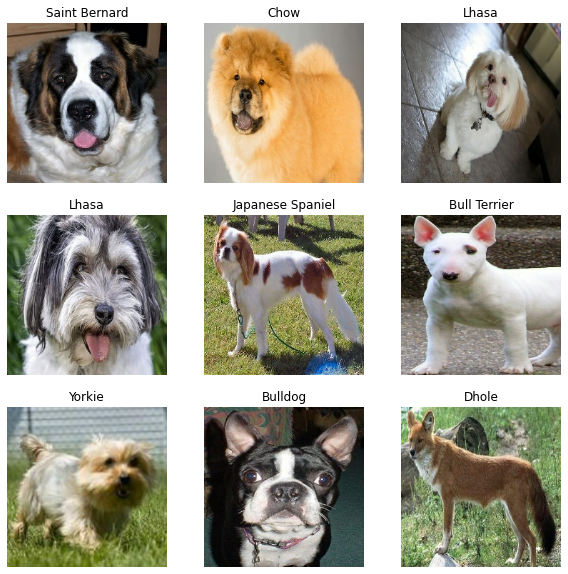

In [6]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

<a name='2'></a>
## 2 - Preprocess and Augment Training Data
 

Using `prefetch()` prevents a memory bottleneck that can occur when reading from disk. It sets aside some data and keeps it ready for when it's needed, by creating a source dataset from your input data, applying a transformation to preprocess it, then iterating over the dataset one element at a time. Because the iteration is streaming, the data doesn't need to fit into memory.

You can set the number of elements to prefetch manually, or you can use `tf.data.experimental.AUTOTUNE` to choose the parameters automatically. Autotune prompts `tf.data` to tune that value dynamically at runtime, by tracking the time spent in each operation and feeding those times into an optimization algorithm. The optimization algorithm tries to find the best allocation of its CPU budget across all tunable operations. 

To increase diversity in the training set and help your model learn the data better, it's standard practice to augment the images by transforming them, i.e., randomly flipping and rotating them. Keras' Sequential API offers a straightforward method for these kinds of data augmentations, with built-in, customizable preprocessing layers. These layers are saved with the rest of your model and can be re-used later.  Ahh, so convenient! 

As always, you're invited to read the official docs, which you can find for data augmentation [here](https://www.tensorflow.org/tutorials/images/data_augmentation).


In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

<a name='ex-1'></a>
### Data_augmenter

Implement a function for data augmentation. Use a `Sequential` keras model composed of 2 layers:
* `RandomFlip('horizontal')`
* `RandomRotation(0.2)`

In [8]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    ### START CODE HERE
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip("horizontal"))
    data_augmentation.add(RandomRotation(0.2))
    ### END CODE HERE
    
    return data_augmentation

Take a look at how an image from the training set has been augmented with simple transformations:

From one cute animal, to 9 variations of that cute animal, in three lines of code. Now your model has a lot more to learn from.

'\naugmented_image = [1,160,160,3]. Added dimension because first dimension = m in tf\naugmented_image[0] means first element of first dimension. This makes it = [160,160,3]\n'

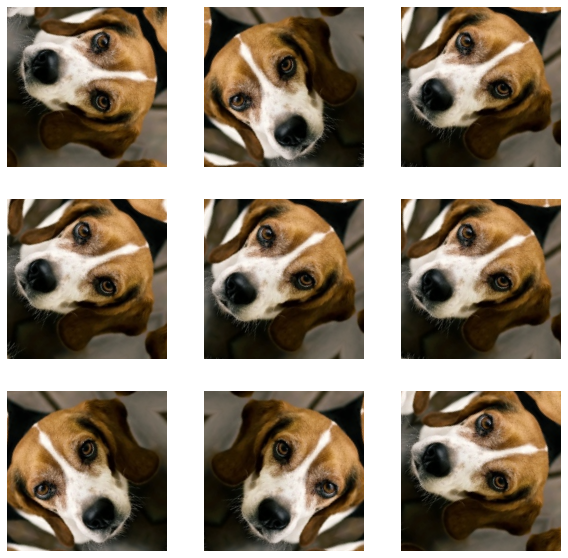

In [9]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0]/255 )
        plt.axis('off')

'''
augmented_image = [1,160,160,3]. Added dimension because first dimension = m in tf
augmented_image[0] means first element of first dimension. This makes it = [160,160,3]
'''

Next, you'll apply your first tool from the MobileNet application in TensorFlow, to normalize your input. Since you're using a pre-trained model that was trained on the normalization values [-1,1], it's best practice to reuse that standard with tf.keras.applications.mobilenet_v2.preprocess_input.

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [11]:
def dogbreed_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    
    input_shape = image_shape + (3,)
    
    ### START CODE HERE
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, #Important!!!!
                                                   weights='imagenet') # From imageNet
    
    # freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x =tfl.GlobalAveragePooling2D()(x)  
    # include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tfl.Dense(70)(x)
    
    ### END CODE HERE
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [12]:
model2 = dogbreed_model(IMG_SIZE, data_augmentation)

In [13]:
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [14]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [15]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
32/32 [==============================] - 170s 5s/step - loss: 2.7611 - accuracy: 0.3447 - val_loss: 1.1569 - val_accuracy: 0.8171
Epoch 2/5
32/32 [==============================] - 160s 4s/step - loss: 1.1315 - accuracy: 0.7019 - val_loss: 0.6655 - val_accuracy: 0.8886
Epoch 3/5
32/32 [==============================] - 132s 4s/step - loss: 0.8407 - accuracy: 0.7596 - val_loss: 0.5757 - val_accuracy: 0.9086
Epoch 4/5
32/32 [==============================] - 133s 4s/step - loss: 0.7417 - accuracy: 0.7869 - val_loss: 0.5209 - val_accuracy: 0.9171
Epoch 5/5
32/32 [==============================] - 134s 4s/step - loss: 0.6637 - accuracy: 0.8038 - val_loss: 0.5091 - val_accuracy: 0.9171


Plot the training and validation accuracy:

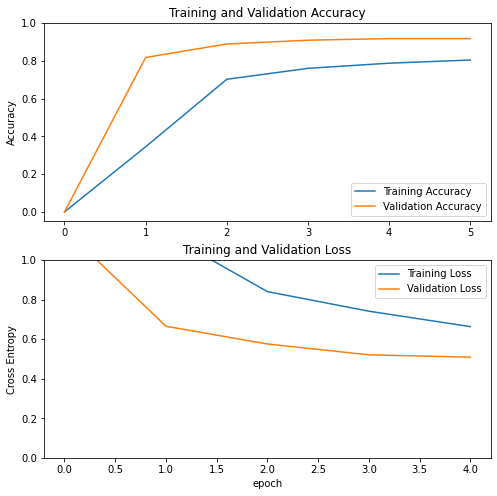

In [16]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [17]:
class_names

['Afghan',
 'African Wild Dog',
 'Airedale',
 'American Hairless',
 'American Spaniel',
 'Basenji',
 'Basset',
 'Beagle',
 'Bearded Collie',
 'Bermaise',
 'Bichon Frise',
 'Blenheim',
 'Bloodhound',
 'Bluetick',
 'Border Collie',
 'Borzoi',
 'Boston Terrier',
 'Boxer',
 'Bull Mastiff',
 'Bull Terrier',
 'Bulldog',
 'Cairn',
 'Chihuahua',
 'Chinese Crested',
 'Chow',
 'Clumber',
 'Cockapoo',
 'Cocker',
 'Collie',
 'Corgi',
 'Coyote',
 'Dalmation',
 'Dhole',
 'Dingo',
 'Doberman',
 'Elk Hound',
 'French Bulldog',
 'German Sheperd',
 'Golden Retriever',
 'Great Dane',
 'Great Perenees',
 'Greyhound',
 'Groenendael',
 'Irish Spaniel',
 'Irish Wolfhound',
 'Japanese Spaniel',
 'Komondor',
 'Labradoodle',
 'Labrador',
 'Lhasa',
 'Malinois',
 'Maltese',
 'Mex Hairless',
 'Newfoundland',
 'Pekinese',
 'Pit Bull',
 'Pomeranian',
 'Poodle',
 'Pug',
 'Rhodesian',
 'Rottweiler',
 'Saint Bernard',
 'Schnauzer',
 'Scotch Terrier',
 'Shar_Pei',
 'Shiba Inu',
 'Shih-Tzu',
 'Siberian Husky',
 'Vizsla',

The results are ok, but could be better. Next, try some fine-tuning.

In [18]:
model2.layers

In [19]:
base_model = model2.layers[4]
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

### START CODE HERE

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate*0.1)
# Use accuracy as evaluation metric
metrics= ['accuracy']

### END CODE HERE

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  154


In [20]:

total_epochs =  10

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         validation_data=validation_dataset)

Epoch 1/10
32/32 [==============================] - 204s 6s/step - loss: 0.6630 - accuracy: 0.7922 - val_loss: 0.5750 - val_accuracy: 0.8986
Epoch 2/10
32/32 [==============================] - 203s 6s/step - loss: 0.5526 - accuracy: 0.8233 - val_loss: 0.5579 - val_accuracy: 0.9186
Epoch 3/10
32/32 [==============================] - 206s 6s/step - loss: 0.4843 - accuracy: 0.8426 - val_loss: 0.5983 - val_accuracy: 0.9086
Epoch 4/10
32/32 [==============================] - 208s 6s/step - loss: 0.4749 - accuracy: 0.8484 - val_loss: 0.5750 - val_accuracy: 0.9271
Epoch 5/10
32/32 [==============================] - 209s 6s/step - loss: 0.4185 - accuracy: 0.8667 - val_loss: 0.6051 - val_accuracy: 0.9300
Epoch 6/10
32/32 [==============================] - 209s 6s/step - loss: 0.3701 - accuracy: 0.8816 - val_loss: 0.6173 - val_accuracy: 0.8986
Epoch 7/10
32/32 [==============================] - 211s 7s/step - loss: 0.4383 - accuracy: 0.8567 - val_loss: 0.6182 - val_accuracy: 0.9157
Epoch 8/10
32

In [21]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

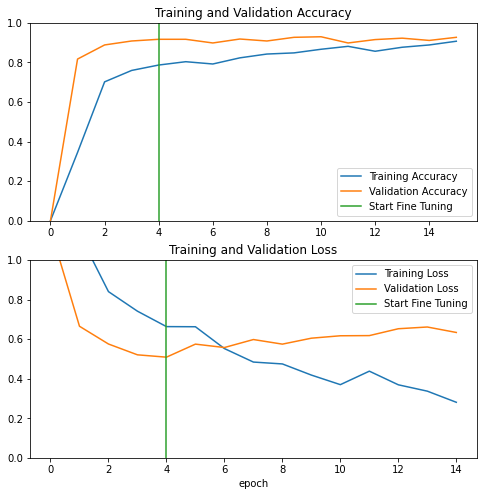

In [22]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Predicting breeds

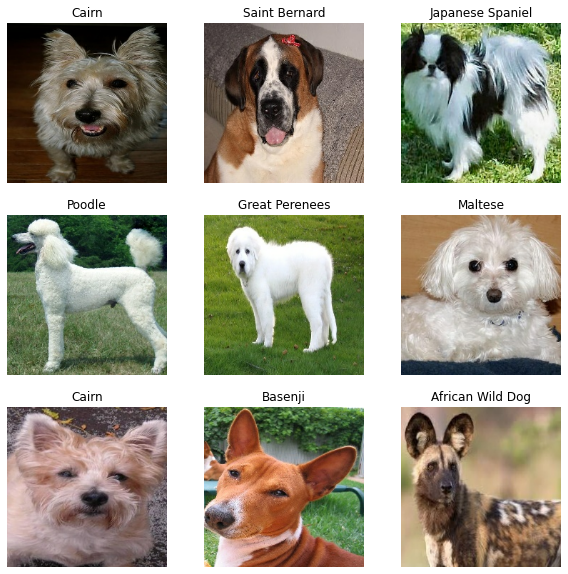

In [66]:
class_names = validation_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in validation_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        pred = model2.predict(tf.expand_dims(images[i], axis=0)).squeeze()
        breed = tf.math.argmax(tf.nn.softmax(pred)).numpy()
        plt.title(class_names[breed])
        
        plt.axis("off")
        
